<a href="https://colab.research.google.com/github/marciamart/Classificacao-Ecommerce/blob/main/classifica%C3%A7%C3%A3o_ecommerce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####intalações e importações

In [1]:
!pip install opendatasets
!apt install libimage-exiftool-perl
!pip install colorgram.py
!pip install imagehash
!pip install opencv-python
!pip install tensorflow

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libarchive-zip-perl libmime-charset-perl libsombok3 libunicode-linebreak-perl
Suggested packages:
  libposix-strptime-perl libencode-hanextra-perl libpod2-base-perl
The following NEW packages will be installed:
  libarchive-zip-perl libimage-exiftool-perl libmime-charset-perl libsombok3
  libunicode-linebreak-perl
0 upgraded, 5 newly installed, 0 to remove and 45 not upgraded.
Need to get 3,964 kB of archives.
After this operation, 23.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libarchive-zip-perl all 1.68-1 [90.2 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libimage-exiftool-perl all 12.40+dfsg-1 [3,717 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libmime-charset-perl all 1.012.2-1 [30.9 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/univers

In [4]:
import opendatasets as od
import os
from PIL import Image
import subprocess
import imghdr
import random
from collections import Counter
import colorgram
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imagehash
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import tensorflow as tf
from sklearn.decomposition import PCA
import shutil
from concurrent.futures import ThreadPoolExecutor

In [5]:
od.download("https://www.kaggle.com/datasets/fatihkgg/ecommerce-product-images-18k")

#USAR API TOKEN DO KAGGLE

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mrciamartins
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/fatihkgg/ecommerce-product-images-18k


100%|██████████| 142M/142M [00:02<00:00, 64.3MB/s]


Dataset em  /content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES

In [6]:
data_dir = '/content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES'
train_dir = "/content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/train"
val_dir = "/content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/val"
test_dir = "/content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/check"

# Parte 1 - Análise do DataSet

## Objetivo e informações esperadas

Objetivo:
* Apresentar informações do dataset.

Informações esperadas:
* Integridade dos Arquivos
  1. Verifique se todas as imagens listadas no arquivo de informações
realmente existem no diretório de imagens e vice-versa.
  2. Verifique se todas as imagens estão no mesmo formato, ex: JPEG,
PNG, etc.
* Consistência dos Metadados
  1. Verifique se há valores ausentes nos metadados e como esses casos
são tratados.
  2. Verifique valores inconsistentes, por exemplo: dimensões de imagens
fora do esperado.
* Qualidade das Imagens
  1. Identifique imagens corrompidas que não podem ser abertas ou
processadas.
* Distribuição das Classes
  1. Verifique a distribuição das classes para identificar possíveis
desequilíbrios que possam afetar a modelagem
* Duplicatas
  1. Identifique imagens duplicadas que possam enviesar os resultados.
  2. Verifique duplicatas no arquivo de informações.

Informações complementares:
* Elaborar uma apresentação para mostrar os resultados.
* Apresentar o dataset de forma detalhada.
* Verifique quais itens em Informações esperadas podem ser aplicados no
dataset.

## **Integridade dos Arquivos**
A função a seguir verifica se todas as imagens no diretório estão no mesmo formato (JPEG, JPG, PNG). Ela retorna um dicionário com os formatos das imagens como chaves e suas respectivas quantidades como valores.

Saída esperada: {'JPEG': 18175}

In [18]:
def verificar_formato_imagem(data):
    formatos = {}
    for raiz, dirs, arquivos in os.walk(data):
        print(raiz)
        for arquivo in arquivos:
            if arquivo.endswith(('jpeg', 'jpg', 'png')):
                caminho_arquivo = os.path.join(raiz, arquivo)
                with Image.open(caminho_arquivo) as img:
                    formato = img.format
                    if formato not in formatos:
                        formatos[formato] = 0
                    formatos[formato] += 1
            else:
                formatos['Desconhecido'] = formatos.get('Desconhecido', 0) + 1

    return formatos

formatos_imagens = verificar_formato_imagem(data_dir)
print(formatos_imagens)

/content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES
/content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/check
/content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/check/BEAUTY_HEALTH
/content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/check/PET_SUPPLIES
/content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/check/HOBBY_ARTS_STATIONERY
/content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/check/ELECTRONICS
/content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/check/BABY_PRODUCTS
/content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/check/SPORTS_OUTDOOR
/content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/check/HOME_KITCHEN_TOOLS
/content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/check/CLOTHING_ACCESSORIES_JEWELLERY
/content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/check/GROCERY
/content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/train
/content/ecommerce-product-ima

## **Consistência dos Metadados**

Nessa etapa, foi analisado a qualidade e a integridade das imagens, para assegurar que não haverá maiores problemas nas etapas seguintes.

Foram levantados os seguintes:


*   Dimensões das imagens
*   Quantidade de megapixes
*   Recorrência de cores




#### **Dimensão das imagens**

Utilizando o conjunto de imagens amostrais, presentes na pasta (train), não foi encontrado alguma inconsistência, uma vez que o conjunto amostral apresenta imagens com as mesmas dimensões.

---
*Saída Esperada*:


```
A dimensão que mais aparece é: (224, 224) (quantidade: 18175)
```






In [ ]:
contagem_dimensoes = Counter()

def verificar_dimensoes_imagens(pasta):
    for item in os.listdir(pasta):
        caminho_item = os.path.join(pasta, item)

        if os.path.isdir(caminho_item):
            verificar_dimensoes_imagens(caminho_item)
        elif os.path.isfile(caminho_item) and imghdr.what(caminho_item) == 'jpeg':
            resultado = subprocess.run(["exiftool", "-s", "-ImageWidth", "-ImageHeight", caminho_item], capture_output=True, text=True)

            dimensoes = resultado.stdout.strip().split("\n")
            largura = int(dimensoes[0].split(": ")[1])
            altura = int(dimensoes[1].split(": ")[1])

            contagem_dimensoes[(largura, altura)] += 1

verificar_dimensoes_imagens(train_dir)
verificar_dimensoes_imagens(val_dir)
verificar_dimensoes_imagens(test_dir)

dimensao_mais_comum = contagem_dimensoes.most_common(1)[0]

print(f"A dimensão que mais aparece é: {dimensao_mais_comum[0]} (quantidade: {dimensao_mais_comum[1]})")


#### **Quantidade de MegaPixels**

Também não foi encontrado dados ausentes ou inconsistentes nesse espaço de dados amostral, uma vez que todas as imagens apresentam a mesma quantidade de megapixels.

---
*Saída Esperada:*



```
Todos os arquivos possuem 0.050 megapixels.

```





In [ ]:
megapixels_esperado = None
arquivos_com_megapixels_diferentes = []

def verificar_megapixels(pasta):
    global megapixels_esperado, arquivos_com_megapixels_diferentes

    for item in os.listdir(pasta):
        caminho_item = os.path.join(pasta, item)

        if os.path.isdir(caminho_item):
            verificar_megapixels(caminho_item)
        elif os.path.isfile(caminho_item) and imghdr.what(caminho_item) == 'jpeg':
            resultado = subprocess.run(["exiftool", "-s", "-Megapixels", caminho_item], capture_output=True, text=True)

            megapixels_atual = resultado.stdout.strip().split(": ")[1]

            if megapixels_esperado is None:
                megapixels_esperado = megapixels_atual
            elif megapixels_atual != megapixels_esperado:
                arquivos_com_megapixels_diferentes.append(caminho_item)

verificar_megapixels(train_dir)
verificar_megapixels(val_dir)
verificar_megapixels(test_dir)

if arquivos_com_megapixels_diferentes:
    print("Nem todos os arquivos possuem o mesmo valor de megapixels.")
    print("Arquivos com megapixels diferentes:")
    for arquivo in arquivos_com_megapixels_diferentes:
        print(f"  - {arquivo}")
else:
    print(f"Todos os arquivos possuem {megapixels_esperado} megapixels.")


#### **Recorrência de Cores**

Nesse levantamento, foi observado que as cores semelhantes ao branco absoluto são as mais presentes nas categorias apresentadas. O algoritmo utilizado analisa a imagem como um todoo, por isso, o fundo "neutro" influênciou nesse resultado. Porém, utilizando o *OpenCV*, é possível detectar os contornos do produto e descobrir as cores além do fundo neutro.


---
*Saída utilizando apenas a biblioteca Colorgram:*



```
Categoria 'BABY_PRODUCTS': Cor predominante: Rgb(r=254, g=254, b=254), Proporção total: 3.05
Categoria 'BEAUTY_HEALTH': Cor predominante: Rgb(r=254, g=254, b=254), Proporção total: 2.03
Categoria 'CLOTHING_ACCESSORIES_JEWELLERY': Cor predominante: Rgb(r=254, g=254, b=254), Proporção total: 6.29
Categoria 'ELECTRONICS': Cor predominante: Rgb(r=253, g=253, b=253), Proporção total: 4.57
Categoria 'GROCERY': Cor predominante: Rgb(r=254, g=254, b=253), Proporção total: 9.50
Categoria 'HOBBY_ARTS_STATIONERY': Cor predominante: Rgb(r=254, g=254, b=254), Proporção total: 2.84
Categoria 'HOME_KITCHEN_TOOLS': Cor predominante: Rgb(r=254, g=254, b=254), Proporção total: 8.90
Categoria 'PET_SUPPLIES': Cor predominante: Rgb(r=253, g=253, b=253), Proporção total: 2.11
Categoria 'SPORTS_OUTDOOR': Cor predominante: Rgb(r=253, g=253, b=253), Proporção total: 12.45
```




In [ ]:
def analisar_cores_por_categoria(pasta):
    dados = []

    for nome_subpasta in os.listdir(pasta):
        caminho_subpasta = os.path.join(pasta, nome_subpasta)
        if os.path.isdir(caminho_subpasta):
            categoria = nome_subpasta

            for item in os.listdir(caminho_subpasta):
                caminho_item = os.path.join(caminho_subpasta, item)
                if os.path.isfile(caminho_item) and imghdr.what(caminho_item) == 'jpeg':
                    try:
                        cores = colorgram.extract(Image.open(caminho_item), 5)  # Extrai 5 cores

                        for cor in cores:
                            dados.append({'categoria': categoria, 'cor_predominante': cor.rgb, 'proporcao': cor.proportion})
                    except Exception as e:
                        print(f"Erro ao processar a imagem {caminho_item}: {e}")

    df = pd.DataFrame(data_dir)

    cores_predominantes_por_categoria = df.groupby(['categoria', 'cor_predominante'])['proporcao'].sum().reset_index()
    cores_predominantes_por_categoria = cores_predominantes_por_categoria.loc[cores_predominantes_por_categoria.groupby('categoria')['proporcao'].idxmax()]

    for _, row in cores_predominantes_por_categoria.iterrows():
        print(f"Categoria '{row['categoria']}': Cor predominante: {row['cor_predominante']}, Proporção total: {row['proporcao']:.2f}")

analisar_cores_por_categoria(train_dir)
analisar_cores_por_categoria(val_dir)
analisar_cores_por_categoria(test_dir)

Após utilizar a ferramenta *OpenCV*, conseguimos observar que, apesar da maioria das categorias ainda seguir na paleta de cores "branco" ou "cinza", a  categoria "BEAUTY_HEALTH" tem uma predominância de cores mais vibrantes e quentes, como o amarelo alaranjado, que podem transmitir a ideia de saúde, vitalidade e beleza, enquanto "BABY_PRODUCTS" tem uma predominância de cores claras e neutras, como o branco e o cinza claro, que são comumente associadas a produtos para bebês.

Cada categoria apresenta a seguinte variedade de cores:


*   BABY_PRODUCTS - **Cinza claro.**
*   HOME_KITCHEN_TOOLS - **Cinza bem claro.**
*   GROCERY - **Um branco com tons de amarelo.**
*   BEAUTY_HEALTH - **Dourado.**
*   CLOTHING_ACCESSORIES_JEWELLERY, ELECTRONICS, HOBBY_ARTS_STATIONERY, PET_SUPPLIES e SPORTS_OUTDOOR - **Branco.**


---

*Saída Esperada:*


>A proporção total indica o percentual que os metadados da categoria representam em relação ao total de dados.



```
Categoria 'BABY_PRODUCTS': Cor predominante: Rgb(r=237, g=237, b=236), Proporção total: 1.73
Categoria 'BEAUTY_HEALTH': Cor predominante: Rgb(r=226, g=165, b=4), Proporção total: 1.20
Categoria 'CLOTHING_ACCESSORIES_JEWELLERY': Cor predominante: Rgb(r=253, g=253, b=253), Proporção total: 1.09
Categoria 'ELECTRONICS': Cor predominante: Rgb(r=253, g=253, b=253), Proporção total: 3.55
Categoria 'GROCERY': Cor predominante: Rgb(r=254, g=254, b=253), Proporção total: 1.69
Categoria 'HOBBY_ARTS_STATIONERY': Cor predominante: Rgb(r=254, g=254, b=254), Proporção total: 1.20
Categoria 'HOME_KITCHEN_TOOLS': Cor predominante: Rgb(r=251, g=251, b=250), Proporção total: 1.61
Categoria 'PET_SUPPLIES': Cor predominante: Rgb(r=253, g=253, b=253), Proporção total: 1.76
Categoria 'SPORTS_OUTDOOR': Cor predominante: Rgb(r=252, g=252, b=252), Proporção total: 3.87

```







In [ ]:
def analisar_cores_por_categoria(pasta):
    dados = []

    for nome_subpasta in os.listdir(pasta):
        caminho_subpasta = os.path.join(pasta, nome_subpasta)
        if os.path.isdir(caminho_subpasta):
            categoria = nome_subpasta

            for item in os.listdir(caminho_subpasta):
                caminho_item = os.path.join(caminho_subpasta, item)
                if os.path.isfile(caminho_item) and imghdr.what(caminho_item) == 'jpeg':
                    try:
                        img = cv2.imread(caminho_item)
                        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

                        _, thresh = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)

                        contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

                        if len(contours) > 0:
                            maior_contorno = max(contours, key=cv2.contourArea)
                            x, y, w, h = cv2.boundingRect(maior_contorno)
                            img_recortada = img[y:y+h, x:x+w]

                            cores = colorgram.extract(Image.fromarray(img_recortada), 5)

                            for cor in cores:
                                dados.append({'categoria': categoria, 'cor_predominante': cor.rgb, 'proporcao': cor.proportion})
                        else:
                            print(f"Nenhum contorno encontrado na imagem {caminho_item}.")

                    except Exception as e:
                        print(f"Erro ao processar a imagem {caminho_item}: {e}")

    df = pd.DataFrame(dados)

    cores_predominantes_por_categoria = df.groupby(['categoria', 'cor_predominante'])['proporcao'].sum().reset_index()
    cores_predominantes_por_categoria = cores_predominantes_por_categoria.loc[cores_predominantes_por_categoria.groupby('categoria')['proporcao'].idxmax()]

    for _, row in cores_predominantes_por_categoria.iterrows():
        print(f"Categoria '{row['categoria']}': Cor predominante: {row['cor_predominante']}, Proporção total: {row['proporcao']:.2f}")

analisar_cores_por_categoria(train_dir)
analisar_cores_por_categoria(val_dir)
analisar_cores_por_categoria(test_dir)

## **Qualidade de imagens**

In [8]:
#Verifica se uma imagem pode ser aberta.
def check_image(image_path):
  try:
    img = cv2.imread(image_path)
    return img is not None
  except Exception as e:
    print(f"Erro ao abrir {image_path}: {str(e)}")
    return False

#Encontra imagens corrompidas em um diretório e seus subdiretórios.
def find_corrupted_images(directory):
  """Encontra imagens corrompidas em um diretório e seus subdiretórios.

  Args:
    directory: Caminho para o diretório raiz.

  Returns:
    Uma lista com os caminhos das imagens corrompidas.
  """
  corrupted_images = []
  for root, _, files in os.walk(directory):
    for file in files:
      if file.endswith(('.jpg', '.jpeg', '.png')):  # Adapte para outros formatos se necessário
        image_path = os.path.join(root, file)
        if not check_image(image_path):
          corrupted_images.append(image_path)
  return corrupted_images

# Definindo os caminhos dos seus diretórios
train_dir = "/content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/train"
val_dir = "/content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/val"
test_dir = "/content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/check"

# Encontrando as imagens corrompidas em cada diretório
corrupted_train = find_corrupted_images(train_dir)
corrupted_val = find_corrupted_images(val_dir)
corrupted_test = find_corrupted_images(test_dir)

# Imprimindo ou salvando os resultados
print("Imagens corrompidas no conjunto de treinamento:")
print(corrupted_train)

print("Imagens corrompidas no conjunto de validação:")
print(corrupted_val)

print("Imagens corrompidas no conjunto de teste:")
print(corrupted_test)

Imagens corrompidas no conjunto de treinamento:
[]
Imagens corrompidas no conjunto de validação:
[]
Imagens corrompidas no conjunto de teste:
[]


##**Distribuição das Classes**
Conjuntos de treinamento (train) e validação (val) para treinamento de modelo e ajuste de hiperparâmetros. E uma pequena amostra, conjunto de verificação (check) para avaliação visual do modelo durante a implantação.

Aqui faremos uma análise da distribuição das imagens nessas classes.

####**TRAIN**

Aqui contaremos quantas imagens possui em cada classe (diretórios)

In [9]:
#análise da distribuição da classe: TRAIN
data =  '/content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/train'
subdiretorios = {}
# Passando por cada subdiretório
for dirpath, dirnames, filenames in os.walk(data):
    if dirpath == data: continue

    num_images = 0
    # Conta o número de imagens no subdiretório
    for filename in filenames:
        if filename.lower().endswith('.jpeg'):
            num_images += 1

    # Imprimi o número de imagens do subdiretório atual
    print(f"São {num_images} imagens no diretório {os.path.basename(dirpath)}")
    subdiretorios[os.path.basename(dirpath)] = num_images

print(f"Subdiretórios: {subdiretorios}")

São 1202 imagens no diretório BEAUTY_HEALTH
São 1260 imagens no diretório PET_SUPPLIES
São 1091 imagens no diretório HOBBY_ARTS_STATIONERY
São 1353 imagens no diretório ELECTRONICS
São 1087 imagens no diretório BABY_PRODUCTS
São 1235 imagens no diretório SPORTS_OUTDOOR
São 1715 imagens no diretório HOME_KITCHEN_TOOLS
São 1071 imagens no diretório CLOTHING_ACCESSORIES_JEWELLERY
São 3978 imagens no diretório GROCERY
Subdiretórios: {'BEAUTY_HEALTH': 1202, 'PET_SUPPLIES': 1260, 'HOBBY_ARTS_STATIONERY': 1091, 'ELECTRONICS': 1353, 'BABY_PRODUCTS': 1087, 'SPORTS_OUTDOOR': 1235, 'HOME_KITCHEN_TOOLS': 1715, 'CLOTHING_ACCESSORIES_JEWELLERY': 1071, 'GROCERY': 3978}


Criando um gráfico de barras para visualização da distribuição das classes

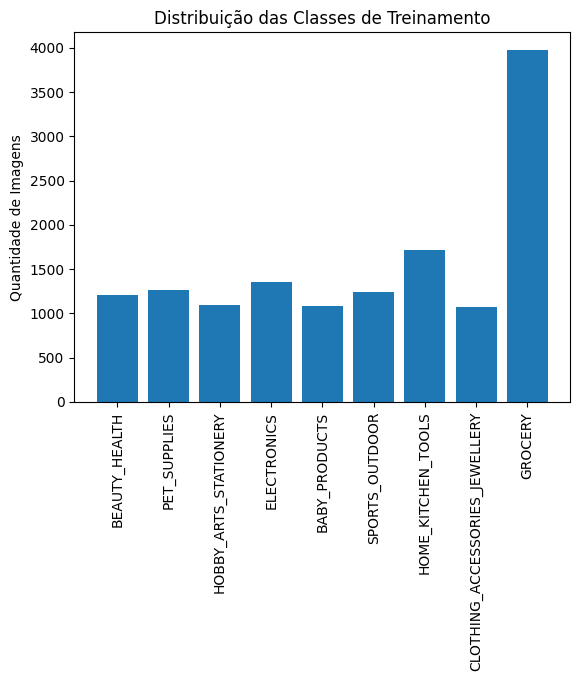

In [10]:
plt.bar(subdiretorios.keys(), subdiretorios.values())
plt.xticks(rotation=90)
plt.ylabel("Quantidade de Imagens")
plt.title("Distribuição das Classes de Treinamento")
plt.show()

Com a análise podemos observar que a classe GROCERY possui significativamente mais instâncias em comparação com as demais classes, sugerindo um desequilíbrio considerável na distribuição das classes no conjunto de dados.

### **CHECK - VAL**
Faremos o mesmo para o conjunto de validação (val) e conjunto de verificação (check)

#### **VAL**

In [11]:
#análise da distribuição da classe: TRAIN
data =  '/content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/val'
subdiretorios = {}
# Passando por cada subdiretório
for dirpath, dirnames, filenames in os.walk(data):
    if dirpath == data: continue

    num_images = 0
    # Conta o número de imagens no subdiretório
    for filename in filenames:
        if filename.lower().endswith('.jpeg'):
            num_images += 1

    # Imprimi o número de imagens do subdiretório atual
    print(f"São {num_images} imagens no diretório {os.path.basename(dirpath)}")
    subdiretorios[os.path.basename(dirpath)] = num_images

print(f"Subdiretórios: {subdiretorios}")

São 312 imagens no diretório BEAUTY_HEALTH
São 327 imagens no diretório PET_SUPPLIES
São 283 imagens no diretório HOBBY_ARTS_STATIONERY
São 351 imagens no diretório ELECTRONICS
São 282 imagens no diretório BABY_PRODUCTS
São 321 imagens no diretório SPORTS_OUTDOOR
São 445 imagens no diretório HOME_KITCHEN_TOOLS
São 278 imagens no diretório CLOTHING_ACCESSORIES_JEWELLERY
São 1033 imagens no diretório GROCERY
Subdiretórios: {'BEAUTY_HEALTH': 312, 'PET_SUPPLIES': 327, 'HOBBY_ARTS_STATIONERY': 283, 'ELECTRONICS': 351, 'BABY_PRODUCTS': 282, 'SPORTS_OUTDOOR': 321, 'HOME_KITCHEN_TOOLS': 445, 'CLOTHING_ACCESSORIES_JEWELLERY': 278, 'GROCERY': 1033}


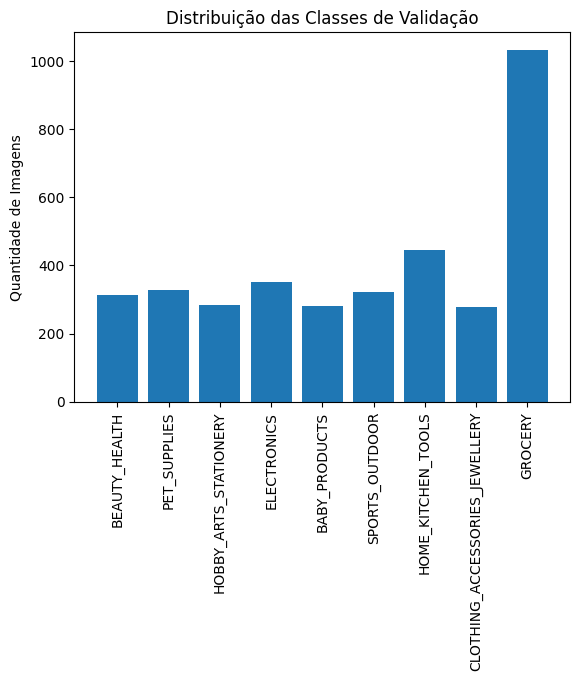

In [12]:


plt.bar(subdiretorios.keys(), subdiretorios.values())
plt.xticks(rotation=90)
plt.ylabel("Quantidade de Imagens")
plt.title("Distribuição das Classes de Validação")
plt.show()

#### **CHECK**

In [13]:
#análise da distribuição da classe: TRAIN
data =  '/content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/check'
subdiretorios = {}
# Passando por cada subdiretório
for dirpath, dirnames, filenames in os.walk(data):
    if dirpath == data: continue

    num_images = 0
    # Conta o número de imagens no subdiretório
    for filename in filenames:
        if filename.lower().endswith('.jpeg'):
            num_images += 1

    # Imprimi o número de imagens do subdiretório atual
    print(f"São {num_images} imagens no diretório {os.path.basename(dirpath)}")
    subdiretorios[os.path.basename(dirpath)] = num_images

print(f"Subdiretórios: {subdiretorios}")

São 48 imagens no diretório BEAUTY_HEALTH
São 50 imagens no diretório PET_SUPPLIES
São 43 imagens no diretório HOBBY_ARTS_STATIONERY
São 53 imagens no diretório ELECTRONICS
São 43 imagens no diretório BABY_PRODUCTS
São 49 imagens no diretório SPORTS_OUTDOOR
São 68 imagens no diretório HOME_KITCHEN_TOOLS
São 42 imagens no diretório CLOTHING_ACCESSORIES_JEWELLERY
São 155 imagens no diretório GROCERY
Subdiretórios: {'BEAUTY_HEALTH': 48, 'PET_SUPPLIES': 50, 'HOBBY_ARTS_STATIONERY': 43, 'ELECTRONICS': 53, 'BABY_PRODUCTS': 43, 'SPORTS_OUTDOOR': 49, 'HOME_KITCHEN_TOOLS': 68, 'CLOTHING_ACCESSORIES_JEWELLERY': 42, 'GROCERY': 155}


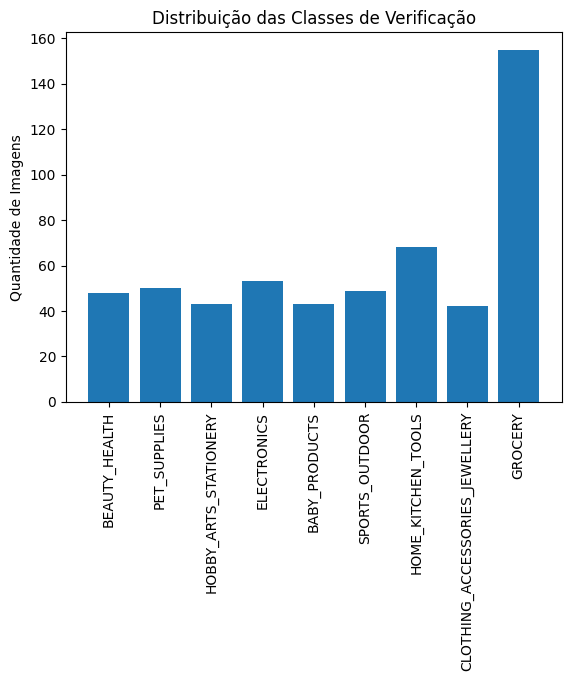

In [14]:
plt.bar(subdiretorios.keys(), subdiretorios.values())
plt.xticks(rotation=90)
plt.ylabel("Quantidade de Imagens")
plt.title("Distribuição das Classes de Verificação")
plt.show()

## **Duplicatas**


1.   Identifique imagens duplicadas que possam enviesar os resultados.

2.   Verifique duplicatas no arquivo de informações.

In [15]:
hashes = {}
duplicatas = []

# Itera sobre as pastas (classes)
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)

    if os.path.isdir(class_path):
        # Itera sobre as imagens dentro da pasta da classe
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)

            try:
                # Carrega a imagem
                with Image.open(image_path) as img:
                    # Calcula o hash perceptual da imagem
                    image_hash = imagehash.average_hash(img)

                # Verifica se o hash já existe no dicionário
                if image_hash in hashes:
                    # Se o hash já existir, marca a imagem como duplicada
                    duplicatas.append((image_path, hashes[image_hash]))
                else:
                    # Se o hash não existir, adiciona ao dicionário
                    hashes[image_hash] = image_path

            except Exception as e:
                print(f"Erro ao processar a imagem: {image_path}. Erro: {e}")
                continue

# Imprime as duplicatas encontradas
if duplicatas:
    print("Imagens duplicadas encontradas:")
    for dup in duplicatas:
        print(f"Duplicada: {dup[0]} \nOriginal: {dup[1]}\n")
else:
    print("Nenhuma imagem duplicada encontrada.")

A saída de streaming foi truncada nas últimas 5000 linhas.
Original: /content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/train/BEAUTY_HEALTH/1447_BEAUTY_train.jpeg

Duplicada: /content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/train/HOME_KITCHEN_TOOLS/11436_HOME_K_train.jpeg 
Original: /content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/train/BEAUTY_HEALTH/1318_BEAUTY_train.jpeg

Duplicada: /content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/train/HOME_KITCHEN_TOOLS/11141_HOME_K_train.jpeg 
Original: /content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/train/HOBBY_ARTS_STATIONERY/8923_HOBBY__train.jpeg

Duplicada: /content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/train/HOME_KITCHEN_TOOLS/10798_HOME_K_train.jpeg 
Original: /content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/train/HOBBY_ARTS_STATIONERY/9583_HOBBY__train.jpeg

Duplicada: /content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/train/HOME_

##Resolução de Problemas encontrados

###Duplicatas

In [16]:
for dup in duplicatas:
    if os.path.dirname(dup[0]) == os.path.dirname(dup[1]):
        if os.path.exists(dup[0]):
            os.remove(dup[0])
            print(f"Imagem duplicada removida: {dup[0]}")

Imagem duplicada removida: /content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/train/BEAUTY_HEALTH/2060_BEAUTY_train.jpeg
Imagem duplicada removida: /content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/train/BEAUTY_HEALTH/2047_BEAUTY_train.jpeg
Imagem duplicada removida: /content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/train/BEAUTY_HEALTH/1566_BEAUTY_train.jpeg
Imagem duplicada removida: /content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/train/BEAUTY_HEALTH/1165_BEAUTY_train.jpeg
Imagem duplicada removida: /content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/train/BEAUTY_HEALTH/2223_BEAUTY_train.jpeg
Imagem duplicada removida: /content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/train/BEAUTY_HEALTH/1601_BEAUTY_train.jpeg
Imagem duplicada removida: /content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/train/BEAUTY_HEALTH/1929_BEAUTY_train.jpeg
Imagem duplicada removida: /content/ecommerce-product-images-18k/ECOM

###Balanceamento de Classes

O código cria um gerador de dados de treinamento com data augmentation, aplicando técnicas como rotação, deslocamento e zoom para aumentar a diversidade das imagens. Em seguida, calcula os pesos das classes para corrigir desbalanceamentos no conjunto de dados e imprime esses pesos em um dicionário. O data augmentation é utilizado para melhorar a capacidade do modelo de generalizar e evitar que ele aprenda apenas características específicas da base de dados, tornando-o mais robusto e capaz de se adaptar a novas bases de dados semelhantes.

Imagem removida: /content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/train/GROCERY/5714_GROCER_train.jpeg
Imagem removida: /content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/train/GROCERY/8243_GROCER_train.jpeg
Imagem removida: /content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/train/GROCERY/4743_GROCER_train.jpeg
Imagem removida: /content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/train/GROCERY/6225_GROCER_train.jpeg
Imagem removida: /content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/train/GROCERY/8418_GROCER_train.jpeg
Imagem removida: /content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/train/GROCERY/4964_GROCER_train.jpeg
Imagem removida: /content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/train/GROCERY/5233_GROCER_train.jpeg
Imagem removida: /content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/train/GROCERY/8390_GROCER_train.jpeg
Imagem removida: /content/ecommerce-product-images-18k/ECOMMERCE

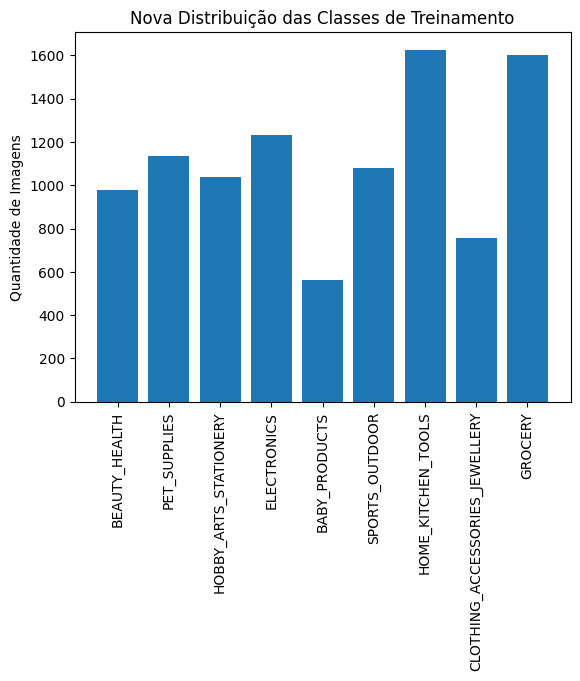

In [17]:
# Nome da classe que será reduzida
classe_alvo = "GROCERY"

# Função para calcular a distribuição de imagens por classe
def calcular_distribuicao_imagens(train_dir):
    distrib_classes = {}
    for classe in os.listdir(train_dir):
        classe_dir = os.path.join(train_dir, classe)
        if os.path.isdir(classe_dir):
            distrib_classes[classe] = len(os.listdir(classe_dir))
    return distrib_classes

# Função para cortar o número de imagens na classe alvo até atingir o novo total desejado
def cortar_imagens_para_balanceamento(train_dir, classe_alvo, novo_total):
    classe_dir = os.path.join(train_dir, classe_alvo)
    imagens = os.listdir(classe_dir)
    num_imagens_atual = len(imagens)

    if num_imagens_atual <= novo_total:
        print(f"A classe {classe_alvo} já está balanceada ou tem menos imagens do que o necessário.")
        return

    # Selecionar aleatoriamente imagens para remover
    imagens_para_remover = random.sample(imagens, num_imagens_atual - novo_total)

    # Remover as imagens selecionadas
    for imagem in imagens_para_remover:
        caminho_imagem = os.path.join(classe_dir, imagem)
        os.remove(caminho_imagem)
        print(f"Imagem removida: {caminho_imagem}")

    print(f"Redução concluída para a classe {classe_alvo}. Total de imagens restantes: {novo_total}")

# Definir o novo número de imagens desejado (1600 imagens)
novo_total = 1600

# Cortar imagens da classe "GROCERY" para que fique com 1600 imagens
cortar_imagens_para_balanceamento(train_dir, classe_alvo, novo_total)

# Calcular a nova distribuição após o balanceamento
nova_distribuicao = calcular_distribuicao_imagens(train_dir)

# Plotar o gráfico de barras com a nova distribuição
plt.bar(nova_distribuicao.keys(), nova_distribuicao.values())
plt.xticks(rotation=90)
plt.ylabel("Quantidade de Imagens")
plt.title("Nova Distribuição das Classes de Treinamento")
plt.show()

# Parte 2 - Exploração de soluções

## Objetivo e informações esperadas

Objetivo:
  * Apresentar métodos da literatura e propor ideias para métodos próprios.

Informações esperadas:
  * Métodos da literatura

    1. Todos devem executar um ou mais códigos (exemplos de códigos podem ser encontrados em Related Notebooks no endereço do dataset) que resolvem o problema do projeto.
  * Métodos próprios
    1. Apresentar ideias que podem melhorar os métodos encontrados e testados da literatura.
    2. Ideias para melhorar uma técnica
      * Otimização de Hiperparâmetros - alterar ou reduzir os hiperparâmetros.
      * Elaborar uma nova arquitetura mais leve para que o treino e o teste sejam rápidos.
      * Reduzir número de imagens no treinamento e manter o desempenho.

Informações complementares:
  * Elaborar uma apresentação para mostrar os métodos da literatura e próprios.


##Pré-processamento de imagens

###Normalização

In [ ]:
normalized_dir = os.path.join(data_dir, 'train_normalizadas')

# Cria o diretório para as imagens normalizadas, caso não exista
if not os.path.exists(normalized_dir):
    os.makedirs(normalized_dir)

# Loop através de todos os subdiretórios e arquivos
for dirpath, dirnames, filenames in os.walk(train_dir):
    # Ignora o diretório raiz, se necessário
    if dirpath == train_dir:
        continue

    for filename in filenames:
        # Caminho completo do arquivo original
        file_path = os.path.join(dirpath, filename)

        # Leitura da imagem
        image = cv2.imread(file_path)

        if image is not None:
            # Conversão para escala de cinza
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            # Normalização da imagem
            normalized_image = gray_image / 255.0

            relative_path = os.path.relpath(dirpath, train_dir)
            new_dir = os.path.join(normalized_dir, relative_path)

            if not os.path.exists(new_dir):
                os.makedirs(new_dir)

            # Caminho completo para salvar a nova imagem
            new_file_path = os.path.join(new_dir, filename)


            # Caminho completo para salvar a nova imagem
            new_file_path = os.path.join(normalized_dir, filename)

            # Salvar a imagem normalizada
            cv2.imwrite(new_file_path, (normalized_image * 255).astype('uint8'))

        else:
            print(f"Erro ao carregar a imagem: {file_path}")


###Redimensionar tamanho

In [ ]:
resized_dir = os.path.join(data_dir, 'train_redimensionadas')

# Defina o novo tamanho para as imagens (largura, altura)
new_size = (300, 200)

# Cria o diretório para as imagens redimensionadas, caso não exista
if not os.path.exists(resized_dir):
    os.makedirs(resized_dir)

# Loop através de todos os subdiretórios e arquivos
for dirpath, dirnames, filenames in os.walk(train_dir):
    # Ignora o diretório raiz, se necessário
    if dirpath == train_dir:
        continue

    for filename in filenames:
        # Caminho completo do arquivo original
        file_path = os.path.join(dirpath, filename)

        # Leitura da imagem
        image = cv2.imread(file_path)

        if image is not None:
            # Redimensionamento da imagem
            resized_image = cv2.resize(image, new_size)

            # Cria o diretório correspondente dentro de 'train_redimensionadas'
            relative_path = os.path.relpath(dirpath, train_dir)
            new_dir = os.path.join(resized_dir, relative_path)

            if not os.path.exists(new_dir):
                os.makedirs(new_dir)

            # Caminho completo para salvar a nova imagem
            new_file_path = os.path.join(new_dir, filename)

            # Salvar a imagem redimensionada
            cv2.imwrite(new_file_path, resized_image)

        else:
            print(f"Erro ao carregar a imagem: {file_path}")

###Conversão para escala de cinza

In [ ]:
# Configurar os caminhos das pastas
source_dir = '/content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/train'
destination_dir = '/content/ecommerce-product-images-18k/ECOMMERCE_PRODUCT_IMAGES/train_escalacinza'

# Criar a pasta de destino se não existir
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

def convert_to_grayscale_and_save(source_dir, destination_dir):
    for root, dirs, files in os.walk(source_dir):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):
                # Caminho completo do arquivo de origem
                source_file_path = os.path.join(root, file)

                # Caminho completo do arquivo de destino
                relative_path = os.path.relpath(root, source_dir)
                dest_subdir = os.path.join(destination_dir, relative_path)
                dest_file_path = os.path.join(dest_subdir, file)

                # Criar subdiretórios no destino, se necessário
                if not os.path.exists(dest_subdir):
                    os.makedirs(dest_subdir)

                # Carregar a imagem
                image = cv2.imread(source_file_path)

                # Converter para escala de cinza
                gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

                # Salvar a imagem convertida na pasta de destino
                cv2.imwrite(dest_file_path, gray_image)

# Converter as imagens e salvar na nova pasta
convert_to_grayscale_and_save(source_dir, destination_dir)

print("Conversão para escala de cinza concluída com sucesso!")


###Filtragem

####Detectação de bordas

In [ ]:
# Define o caminho da nova pasta de saída
output_folder = os.path.join(data_dir, f"train_detecbordas")

# Certifique-se de que o diretório de saída existe
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Itera sobre as pastas (classes)
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)

    if os.path.isdir(class_path):
        # Cria a pasta correspondente no diretório de saída
        output_class_path = os.path.join(output_folder, class_name)
        if not os.path.exists(output_class_path):
            os.makedirs(output_class_path)

        # Itera sobre as imagens dentro da pasta da classe
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)

            # Carrega a imagem
            image = cv2.imread(image_path, 0)  # Carrega em escala de cinza

            # Verifica se a imagem foi carregada corretamente
            if image is None:
                print(f"Erro ao carregar a imagem: {image_path}")
                continue

            # Detecta bordas usando o algoritmo de Canny
            edges = cv2.Canny(image, 100, 200)

            # Define o caminho de saída para a imagem processada
            output_image_path = os.path.join(output_class_path, image_name)

            # Salva a imagem processada
            cv2.imwrite(output_image_path, edges)

print(f"Processamento concluído! Imagens salvas em: {output_folder}")

####Realce


In [ ]:
output_folder = os.path.join(data_dir, "train_realce")

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)

    if os.path.isdir(class_path):
        output_class_path = os.path.join(output_folder, class_name)
        if not os.path.exists(output_class_path):
            os.makedirs(output_class_path)

        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            image_gray = cv2.imread(image_path, 0)
            if image_gray is None:
                print(f"Erro ao carregar a imagem: {image_path}")
                continue

            clahe_image = clahe.apply(image_gray)
            output_image_path = os.path.join(output_class_path, image_name)
            cv2.imwrite(output_image_path, clahe_image)

print(f"Processamento concluído! Imagens salvas em: {output_folder}")

####Suavização

In [ ]:
output_folder = os.path.join(train_dir, "train_suavizacaomediana")

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

for class_name in os.listdir(train_dir):
    class_path = os.path.join(data_dir, class_name)

    if os.path.isdir(class_path):
        # Cria a pasta correspondente no diretório de saída
        output_class_path = os.path.join(output_folder, class_name)
        if not os.path.exists(output_class_path):
            os.makedirs(output_class_path)

        # Itera sobre as imagens dentro da pasta da classe
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)

            # Carrega a imagem
            image = cv2.imread(image_path, 0)  # Carrega em escala de cinza

            # Verifica se a imagem foi carregada corretamente
            if image is None:
                print(f"Erro ao carregar a imagem: {image_path}")
                continue

            # Aplica o filtro de mediana (com kernel de tamanho 5x5)
            median_filtered_image = cv2.medianBlur(image, 5)

            # Define o caminho de saída para a imagem processada
            output_image_path = os.path.join(output_class_path, image_name)

            # Salva a imagem processada
            cv2.imwrite(output_image_path, median_filtered_image)

print(f"Processamento concluído! Imagens salvas em: {output_folder}")

####Correção de contraste

In [ ]:
output_folder = os.path.join(data_dir, "train_contraste")

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)

    if os.path.isdir(class_path):
        output_class_path = os.path.join(output_folder, class_name)
        if not os.path.exists(output_class_path):
            os.makedirs(output_class_path)

        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)

            image = cv2.imread(image_path, 0)  # Carrega em escala de cinza

            if image is None:
                print(f"Erro ao carregar a imagem: {image_path}")
                continue

            equalized_image = cv2.equalizeHist(image)
            output_image_path = os.path.join(output_class_path, image_name)
            cv2.imwrite(output_image_path, equalized_image)

print(f"Processamento concluído! Imagens salvas em: {output_folder}")